# How to Build an Image Recommendation System for Online Retail using Contrastive Learning (and at scale!)
## (work in progress)

In this article, you will learn the end to end process of building a recommender that uses a model trained using similarity learning, a novel machine learning approach more suitable for finding similar items. You will use the Tensorflow_similarity library to train the model and Spark, combined with Horovod, to scale the model training across a GPU cluster. Mlflow will be used to log and track all aspects of the process and Delta will be used to preserve data lineage and reproducibility.

At a high level, similarity models are trained using contrastive learning. In contrastive learning, the goal is to make the machine learning a model (an adaptive algorithm) learn an embedding space where the distance between similar items are minimized and distance between dissimilar items are maximized. In this quickstart we will use the fashion MNIST dataset, which comprises of around 70,000 images of various clothing items. Based on the above description, a similarity model trained on this labelled dataset will learn an embedding space where embeddings of similar items e.g. boots are closer together and different items e.g. boots and bandanas are far apart. 

This could be illustrated as below.

In [0]:
displayHTML("<img src='https://github.com/AviSoori1x/Databricks_image_recommender/blob/main/images/simrec_emb.png?raw=true'>")

If you perform dimensionality reduction and visualize the location of each image with respect to the three principal components, certain visually similar items will be closer to one another and dissimilar items will be farther apart. In similarity learning, the goal is to teach the model to discover a space where the similar items are grouped closer to each other and dissimilar items are separated even more. In supervised similarity learning, the algorithms has access to image labels to learn from, in addition to the image data itself.

In [0]:
displayHTML("<img src='https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/embedding.gif'>")

## Set up

Enter some details about the cluster configurations (i.e. GPU cluster with 2 or more worker nodes to leverage distributed compute). You have to install tensorflow_similarity at the cluster level for the Horovod workflows to work. If you plan on not doing distributed training with Horovod, please uncomment the code in the first code block and get going! (Note: You do not need tensorflow_similarity installed at the cluster level for distributed training across the cluster. Notebook level install is sufficient for Hyperopt)

Imports are as follows:

In [0]:
import numpy as np
from tabulate import tabulate
from matplotlib import pyplot as plt
import mlflow
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from pyspark.ml.feature import OneHotEncoder

# install TF similarity if needed
# try:
#     import tensorflow_similarity as tfsim  # main package
# except:
#     !pip install tensorflow_similarity
#     
import tensorflow_similarity as tfsim
from tensorflow_similarity.utils import tf_cap_memory
from tensorflow_similarity.layers import MetricEmbedding # row wise L2 norm
from tensorflow_similarity.losses import MultiSimilarityLoss  # specialized similarity loss
from tensorflow_similarity.models import SimilarityModel # TF model with additional features
from tensorflow_similarity.samplers import MultiShotMemorySampler  # sample data 
from tensorflow_similarity.samplers import select_examples  # select n example per class
from tensorflow_similarity.visualization import viz_neigbors_imgs  # neigboors vizualisation
from tensorflow_similarity.visualization import confusion_matrix  # matching performance

Note the version of the Tensorflow and Tensorflow similarity libraries that are installed.

In [0]:
print('TensorFlow:', tf.__version__)
print('TensorFlow Similarity', tfsim.__version__)


TensorFlow: 2.6.0
TensorFlow Similarity 0.14.8

Run the two cells below to fetch the data from the official fashion MNIST repo by Zalando (cited in the blog) and create the delta tables

In [0]:
%sh 

wget -O  test_labels.gz https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-labels-idx1-ubyte.gz
wget -O  test_images.gz https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-images-idx3-ubyte.gz
wget -O  train_images.gz https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-images-idx3-ubyte.gz
wget -O  train_labels.gz https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-labels-idx1-ubyte.gz


gunzip -dk *.gz

rm -r train_labels.gz test_labels.gz train_images.gz test_images.gz

ls

--2021-12-16 04:59:13-- https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-labels-idx1-ubyte.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-labels-idx1-ubyte.gz [following]
--2021-12-16 04:59:13-- https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-labels-idx1-ubyte.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5148 (5.0K) [application/octet-stream]
Saving to: ‘test_labels.gz’

 0K ..... 100% 41.4M=0s

2021-12-16 04:59:13 (41.4 MB/s) - ‘test_labels.gz’ saved [5148/5148]

--2021-12-16 04:59:13-- https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-images-idx3-ubyte.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-images-idx3-ubyte.gz [following]
--2021-12-16 04:59:13-- https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-images-idx3-ubyte.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4422102 (4.2M) [application/octet-stream]
Saving to: ‘test_images.gz’

 0K .......... .......... .......... .......... .......... 1% 10.2M 0s
 50K .......... .......... .......... .......... .......... 2% 10.1M 0s
 100K .......... .......... .......... .......... .......... 3% 37.0M 0s
 150K .......... .......... .......... .......... .......... 4% 34.7M 0s
 200K .......... .......... .......... .......... .......... 5% 22.5M 0s
 250K .......... .......... .......... .......... .......... 6% 39.7M 0s
 300K .......... .......... .......... .......... .......... 8% 32.8M 0s
 350K .......... .......... .......... .......... .......... 9% 48.4M 0s
 400K .......... .......... .......... .......... .......... 10% 69.0M 0s
 450K .......... .......... .......... .......... .......... 11% 52.6M 0s
 500K .......... .......... .......... .......... .......... 12% 88.0M 0s
 550K .......... .......... .......... .......... .......... 13% 72.1M 0s
 600K .......... .......... .......... .......... .......... 15% 77.2M 0s
 650K .......... .......... .......... .......... .......... 16% 78.2M 0s
 700K .......... .......... .......... .......... .......... 17% 96.9M 0s
 750K .......... .......... .......... .......... .......... 18% 193M 0s
 800K .......... .......... .......... .......... .......... 19% 84.8M 0s
 850K .......... .......... .......... .......... .......... 20% 89.0M 0s
 900K .......... .......... .......... .......... .......... 21% 88.8M 0s
 950K .......... .......... .......... .......... .......... 23% 183M 0s
 1000K .......... .......... .......... .......... .......... 24% 92.6M 0s
 1050K .......... .......... .......... .......... .......... 25% 139M 0s
 1100K .......... .......... .......... .......... .......... 26% 157M 0s
 1150K .......... .......... .......... .......... .......... 27% 108M 0s
 1200K .......... .......... .......... .......... .......... 28% 165M 0s
 1250K .......... .......... .......... .......... .......... 30% 192M 0s
 1300K .......... .......... .......... .......... .......... 31% 206M 0s
 1350K .......... .......... .......... .......... .......... 32% 167M 0s
 1400K .......... ..........

In [0]:
#The function below, adapted from https://pjreddie.com/projects/mnist-in-csv/, is for converting the datasets downloaded above to delta tables corresponding to train and test


datasets = [['test_images', 'test_labels','/FileStore/tables/user/delta/fmnist_test_data', 10000],  ['train_images', 'train_labels', '/FileStore/tables/user/delta/fmnist_train_data', 60000]]


def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)
        
    f.close()
    l.close()
    df  = pd.DataFrame(images)
    sparkdf = spark.createDataFrame(df)
    sparkdf.write.format('delta').mode('overwrite').save(outf)
    
    



In [0]:
for dataset in datasets:
  convert(dataset[0], dataset[1], dataset[2], dataset[3])

Follow the instructions in the images to upload the fashion mnist train and test datasets from the repo 
Then create delta tables for ease of tracking downstream with mlflow

In [0]:
#The classes in the fashion mnist dataset
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Read the delta tables into train and test datasets

In [0]:
train = spark.read.format("delta").load("/FileStore/tables/user/delta/fmnist_train_data").toPandas().values
test = spark.read.format("delta").load("/FileStore/tables/user/delta/fmnist_test_data").toPandas().values

Define function to shape the image data to a form that the model training process could accomodate. This function is entirely a function of what your image data looks like and what model architecture you choose

In [0]:
def get_dataset(num_classes, train, test, rank=0, size=1):
  from tensorflow import keras
  import numpy as np
  
  np.random.shuffle(train)
  np.random.shuffle(test)

  x_train = train[:, 1:].reshape(-1, 28, 28)
  y_train = train[:, 0].astype(np.int32)
  x_test = test[:, 1:].reshape(-1, 28, 28)
  y_test = test[:, 0].astype(np.int32)

  x_train = x_train[rank::size]
  y_train = y_train[rank::size]
  x_test = x_test[rank::size]
  y_test = y_test[rank::size]

  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255.0
  x_test /= 255.0
  return (x_train, y_train), (x_test, y_test)

Define the model architecture. The beauty of similarity learning is that you can observe siginificantly robust performance with relatively simple convolutional neural network architecture

In [0]:
def get_model():
    from tensorflow_similarity.layers import MetricEmbedding
    from tensorflow.keras import layers
    from tensorflow_similarity.models import SimilarityModel
    
    inputs = layers.Input(shape=(28, 28, 1))
    x = layers.experimental.preprocessing.Rescaling(1/255)(inputs)
    x = layers.Conv2D(16, 3, activation='relu')(x)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPool2D(2, 2)(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    # tune the embedding size to tune the look up times. Smaller embeddings will result in quicker look up times but less accurate results. The converse is true for larger embeddings.
    outputs = MetricEmbedding(128)(x)
    return SimilarityModel(inputs, outputs)

## Train the machine learning model on a single GPU and track model parameters/ metrics

In [0]:
# Specify training parameters
batch_size = 128
epochs = 2
num_classes = 10

Define a function for training the model with the architecture and datasets prescribed above

In [0]:
def train_model(train, test, learning_rate=0.001):
  from tensorflow import keras
  from tensorflow_similarity.losses import MultiSimilarityLoss  # specialized similarity loss
  from tensorflow_similarity.samplers import MultiShotMemorySampler
  from tensorflow.keras.optimizers import Adam
  import mlflow
  mlflow.tensorflow.autolog()
  #The number of classes in the Fashion MNIST dataset is 10
  (x_train, y_train), (x_test, y_test) = get_dataset(num_classes, train, test)
  CLASSES = [2, 3, 1, 7, 9, 6, 8, 5, 0, 4]
  #The number of classes used to train the model. The idea is that a similarity model can generalize well into hitherto unseen classes. 
  #So 6 out of the 10 classes in the Fashion MNIST dataset will be used to train the model.
  NUM_CLASSES = 6   
  CLASS_PER_BATCH = NUM_CLASSES
  EXAMPLE_PER_CLASS = 6  
  EPOCHS = 10
  STEPS_PER_EPOCH = 1000  

  sampler = MultiShotMemorySampler(x_train, y_train, 
                                   classes_per_batch=CLASS_PER_BATCH, 
                                   examples_per_class_per_batch=EXAMPLE_PER_CLASS,
                                   class_list=CLASSES[:NUM_CLASSES], # Only use the first 6 classes for training.
                                   steps_per_epoch=STEPS_PER_EPOCH)
  model = get_model()
  distance = 'cosine' 
  loss = MultiSimilarityLoss(distance=distance)
  model.compile(optimizer=Adam(learning_rate), loss=loss)
  model.fit(sampler, epochs=EPOCHS, validation_data=(x_test, y_test))
  return model 

In [0]:
model = train_model(train, test, learning_rate=0.001)

The initial batch size is 36 (6 classes * 6 examples per class) with 0 augmenters
filtering examples: 0%| | 0/60000 [00:00<?, ?it/s]
selecting classes: 0%| | 0/6 [00:00<?, ?it/s]
gather examples: 0%| | 0/36000 [00:00<?, ?it/s]
indexing classes: 0%| | 0/36000 [00:00<?, ?it/s]
Distance metric automatically set to cosine use the distance arg to override.
2021/12/16 05:36:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '191645a4a39e448ca29d12103604b2d1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
Epoch 1/10
 1/1000 [..............................] - ETA: 10:00 - loss: 1.9751 3/1000 [..............................] - ETA: 50s - loss: 1.9673 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0040s vs `on_train_batch_end` time: 0.0156s). Check your callbacks.
WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0040s vs `on_train_batch_end` time: 0.0156s). Check your callbacks.
 17/1000 [..............................] - ETA: 9s - loss: 1.9641  30/1000 [..............................] - ETA: 6s - loss: 1.9638 44/1000 [>.............................] - ETA: 5s - loss: 1.9637 57/1000 [>.............................] - ETA: 5s - loss: 1.9636 71/1000 [=>............................] - ETA: 4s - loss: 1.9693 84/1000 [=>............................] - ETA: 4s - loss: 1.9831 97/1000 [=>............................] - ETA: 4s - loss: 1.9955 111/1000 [==>...........................] - ETA: 4s - loss: 2.0017 125/1000 [==>...........................] - ETA: 4s - loss: 2.0076 139/1000 [===>..........................] - ETA: 3s - loss: 2.0114 153/1000 [===>..........................] - ETA: 3s - loss: 2.0159 166/1000 [===>..........................] - ETA: 3s - loss: 2.0171 179/1000 [====>.........................] - ETA: 3s - loss: 2.0190 193/1000 [====>.........................] - ETA: 3s - loss: 2.0194 206/1000 [=====>........................] - ETA: 3s - loss: 2.0184 220/1000 [=====>........................] - ETA: 3s - loss: 2.0221 234/1000 [======>.......................] - ETA: 3s - loss: 2.0209 248/1000 [======>.......................] - ETA: 3s - loss: 2.0223 260/1000 [======>.......................] - ETA: 3s - loss: 2.0214 274/1000 [=======>......................] - ETA: 3s - loss: 2.0190 287/1000 [=======>......................] - ETA: 2s 

## Train across a cluster of GPUs with Horovod and Spark

For Horovod to work, tensorflow_similarity has to be installed at the cluster level.

In [0]:
import os
import time

# Remove any existing checkpoint files
dbutils.fs.rm(("/avi_ml/MNISTDemo/train"), recurse=True)

# Create directory
checkpoint_dir = '/dbfs/avi_ml/MNISTDemo/train/{}/'.format(time.time())
os.makedirs(checkpoint_dir)
print(checkpoint_dir)

/dbfs/avi_ml/MNISTDemo/train/1639633130.1513572/

In [0]:
def train_hvd(train, test, checkpoint_path, learning_rate=0.001):
  import tensorflow as tf
  from tensorflow.keras import layers
  from tensorflow.keras.models import load_model
  from tensorflow.keras.optimizers import Adam
  #Horovod flavor matters
  from tensorflow import keras
  import horovod.tensorflow.keras as hvd
  import mlflow
  
  
  
  from tensorflow_similarity.utils import tf_cap_memory
  from tensorflow_similarity.layers import MetricEmbedding # row wise L2 norm
  from tensorflow_similarity.losses import MultiSimilarityLoss  # specialized similarity loss
  from tensorflow_similarity.models import SimilarityModel # TF model with additional features
  from tensorflow_similarity.samplers import MultiShotMemorySampler  # sample data 
  from tensorflow_similarity.samplers import select_examples  # select n example per class
  from tensorflow_similarity.visualization import viz_neigbors_imgs  # neigboors vizualisation
  from tensorflow_similarity.visualization import confusion_matrix  # matching performance
  
  
  
  # Initialize Horovod
  hvd.init()

  
  batch_size = 128
  num_classes = 10

  # Pin GPU to be used to process local rank (one GPU per process)
  # These steps are skipped on a CPU cluster
  gpus = tf.config.experimental.list_physical_devices('GPU')
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
  if gpus:
    tf.config.experimental.set_visible_devices(gpus[hvd.local_rank()], 'GPU')
    
  (x_train, y_train), (x_test, y_test) = get_dataset(num_classes, train, test, hvd.rank(), hvd.size())
  CLASSES = [2, 3, 1, 7, 9, 6, 8, 5, 0, 4]
  NUM_CLASSES = 6  #@param {type: "slider", min: 1, max: 10}
  CLASS_PER_BATCH = NUM_CLASSES
  EXAMPLE_PER_CLASS = 6 #@param {type:"integer"}
  EPOCHS = 2
  STEPS_PER_EPOCH = 1000 #@param {type:"integer"}
  
  
  model = get_model()
  
  # Adjust learning rate based on number of GPUs
  optimizer = keras.optimizers.Adadelta(lr=learning_rate * hvd.size())

  # Use the Horovod Distributed Optimizer
  optimizer = hvd.DistributedOptimizer(optimizer)
  
  

  # Create a callback to broadcast the initial variable states from rank 0 to all other processes.
  callbacks = [hvd.callbacks.BroadcastGlobalVariablesCallback(0),]
  # This is required to ensure consistent initialization of all workers when training is started with random weights or restored from a checkpoint.
 
  
  sampler = MultiShotMemorySampler(x_train, y_train, 
                                   classes_per_batch=CLASS_PER_BATCH, 
                                   examples_per_class_per_batch=EXAMPLE_PER_CLASS,
                                   class_list=CLASSES[:NUM_CLASSES], # Only use the first 6 classes for training.
                                   steps_per_epoch=STEPS_PER_EPOCH)
  
  

  distance = 'cosine' 
  loss = MultiSimilarityLoss(distance=distance)
  

  
  
  model.compile(optimizer=Adam(learning_rate), loss=loss)
  


  # Save checkpoints only on worker 0 to prevent conflicts between workers
  if hvd.rank() == 0:
      mlflow.keras.autolog()
      

      callbacks.append(keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only = True))
      
  model.fit(sampler, callbacks = callbacks ,epochs=EPOCHS, validation_data=(x_test, y_test))

In [0]:
with mlflow.start_run() as run:  
  from sparkdl import HorovodRunner
  from tensorflow_similarity.losses import MultiSimilarityLoss  # specialized similarity loss
  import mlflow

  checkpoint_path = checkpoint_dir + '/checkpoint-{epoch}.ckpt'
  learning_rate = 0.001
   
  
  # Run HorovodRunner
  hr = HorovodRunner(np=2, driver_log_verbosity='all')

  hr.run(train_hvd,  train  = train, test = test, checkpoint_path=checkpoint_path, learning_rate=learning_rate)
  
  distance = 'cosine' 

  loss = MultiSimilarityLoss(distance=distance)

  hvd_model = get_model()

  optimizer=Adam(learning_rate)

  hvd_model.compile(optimizer=Adam(learning_rate), loss=loss)

  hvd_model.load_weights(tf.train.latest_checkpoint(os.path.dirname(checkpoint_path)))

  (x_train, y_train), (x_test, y_test) = get_dataset(num_classes, train, test)

  score = hvd_model.evaluate(x_test, y_test, verbose=0)

  mlflow.log_metric("loss", score)
  mlflow.log_param("lr", learning_rate)

  
mlflow.end_run()

INFO:HorovodRunner:The global names read or written to by the pickled function are {'get_dataset', 'get_model'}.
INFO:HorovodRunner:The pickled object size is 439604899 bytes.
WARNING:HorovodRunner:The pickled object size is greater than 10MB. It might cause training slow to start. You might
consider:
* Loading large datasets inside the main function instead of materializing them on the driver.
* Avoid pulling unnecessary variables from the notebook context.
INFO:HorovodRunner:
### How to enable Horovod Timeline? ###
HorovodRunner has the ability to record the timeline of its activity with Horovod Timeline. To
record a Horovod Timeline, set the `HOROVOD_TIMELINE` environment variable to the location of the
timeline file to be created. You can then open the timeline file using the chrome://tracing
facility of the Chrome browser.

/databricks/spark/python/pyspark/sql/context.py:82: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 warnings.warn(
INFO:HorovodRunner:Start training.
Warning: Permanently added '10.139.64.13' (ECDSA) to the list of known hosts.
[1,0]<stderr>:Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
[1,0]<stderr>:For maximum performance, you can install NMSLIB from sources
[1,0]<stderr>:pip install --no-binary :all: nmslib
[1,0]<stderr>:Registering at the factory, space: dummy distance type: INT
[1,0]<stderr>:Registering at the factory, space: dummy distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: bit_hamming distance type: INT
[1,0]<stderr>:Registering at the factory, space: bit_jaccard distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: leven distance type: INT
[1,0]<stderr>:Registering at the factory, space: normleven distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: kldivfast distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: kldivfastrq distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: kldivgenfast distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: kldivgenslow distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: kldivgenfastrq distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: itakurasaitofast distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: jsdivslow distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: jsdivfast distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: jsdivfastapprox distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: jsmetrslow distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: jsmetrfast distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: jsmetrfastapprox distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: word_embed distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: lp distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: linf distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: l1 distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: l2 distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: cosinesimil distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: angulardist distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: negdotprod distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: lp_sparse distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: linf_sparse distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: l1_sparse distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: l2_sparse distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: cosinesimil_sparse distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: angulardist_sparse distance type: FLOAT
[1,0]<stderr>:Registering at the factory, space: negdotprod_sparse dista

## Distributed Hyperparameter optimization with Hyperopt and Spark

Define a training function to use with hyperopt. This is very similar to the training functions defined earlier.

In [0]:
def train_hyperopt(space):
  from tensorflow import keras
  from tensorflow_similarity.losses import MultiSimilarityLoss  # specialized similarity loss
  from tensorflow_similarity.samplers import MultiShotMemorySampler
  from tensorflow.keras.optimizers import Adam
  import mlflow
  
  mlflow.tensorflow.autolog()


  (x_train, y_train), (x_test, y_test) = get_dataset(num_classes, train, test )
  CLASSES = [2, 3, 1, 7, 9, 6, 8, 5, 0, 4]
  NUM_CLASSES = space['num_classes']  
  CLASS_PER_BATCH = NUM_CLASSES
  EXAMPLE_PER_CLASS = space['examples_per_class']  
  EPOCHS = 10
  STEPS_PER_EPOCH = space['steps_per_epoch'] 

  sampler = MultiShotMemorySampler(x_train, y_train, 
                                   classes_per_batch=CLASS_PER_BATCH, 
                                   examples_per_class_per_batch=EXAMPLE_PER_CLASS,
                                   class_list=CLASSES[:NUM_CLASSES], # Only use the first 6 classes for training.
                                   steps_per_epoch=STEPS_PER_EPOCH)
  model = get_model()
  distance = space["distance"]  
  loss = MultiSimilarityLoss(distance=distance)
  model.compile(optimizer=Adam(space["learning_rate"]), loss=loss)
  model.fit(sampler, epochs=EPOCHS, validation_data=(x_test, y_test))
  return model.evaluate(x_test, y_test)

Import the necessary packages and define the hyperparameter search space as a dictionary

In [0]:
import numpy as np
from hyperopt import fmin, hp, tpe, STATUS_OK, SparkTrials

space = {
  'steps_per_epoch': hp.choice('steps_per_epoch', np.arange(100, 2000, 250, dtype=int)),
  'examples_per_class' : hp.choice('examples_per_class',np.arange(5, 10, 1, dtype=int)),
  'num_classes' : hp.choice('num_classes', np.arange(3, 7, 2, dtype=int)),
  'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
  'distance': hp.choice('distance', ["cosine", "L2", "L1"]),
}

Create an instance of Sparktrials with parallelism of 2 as we only have two workers in this cluster. Change this value according to the number of workers in your cluster.

In [0]:
import mlflow
trials = SparkTrials(2)

Define the hyperparameter search alogorithm and start the search. Because you're using SparkTrials as defined above you're doing this in a distributed manner across your spark cluster.

In [0]:
algo=tpe.suggest
 
with mlflow.start_run():
  best_params = fmin(
    fn=train_hyperopt,
    space=space,
    algo=algo,
    max_evals=8,
    trials = trials,
    return_argmin=False,
  )

INFO:hyperopt-spark:Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
INFO:hyperopt-spark:To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
 0%| | 0/8 [00:00<?, ?trial/s, best loss=?] /databricks/spark/python/pyspark/rdd.py:980: FutureWarning: Deprecated in 3.1, Use pyspark.InheritableThread with the pinned thread mode enabled.
 warnings.warn(

 0%| | 0/8 [00:01<?, ?trial/s, best loss=?] 12%|█▎ | 1/8 [01:18<09:07, 78.25s/trial, best loss: 1.4616304636001587] 25%|██▌ | 2/8 [01:38<04:23, 44.00s/trial, best loss: 1.4616304636001587] 38%|███▊ | 3/8 [02:08<03:08, 37.62s/trial, best loss: 1.4616304636001587] 50%|█████ | 4/8 [02:47<02:32, 38.18s/trial, best loss: 1.4616304636001587] 62%|██████▎ | 5/8 [03:00<01:27, 29.11s/trial, best loss: 1.4616304636001587] 75%|███████▌ | 6/8 [03:41<01:06, 33.17s/trial, best loss: 1.4616304636001587] 88%|████████▊ | 7/8 [04:16<00:33, 33.82s/trial, best loss: 1.4485082626342773]100%|██████████| 8/8 [05:20<00:00, 43.45s/trial, best loss: 1.4485082626342773]100%|██████████| 8/8 [05:20<00:00, 40.08s/trial, best loss: 1.4485082626342773]
INFO:hyperopt-spark:Total Trials: 8: 8 succeeded, 0 failed, 0 cancelled.

Figure out the best parameters that were discovered by the above process.

In [0]:
print(best_params)

{'distance': 'L2', 'examples_per_class': 8, 'learning_rate': 0.048064943172428806, 'num_classes': 5, 'steps_per_epoch': 1600}

Use these paramters to train a model to build an index, which will then be used to querying.

In [0]:
#Train final model 
(x_train, y_train), (x_test, y_test) = get_dataset(num_classes, train, test)
CLASSES = [2, 3, 1, 7, 9, 6, 8, 5, 0, 4]
NUM_CLASSES = 5   
CLASS_PER_BATCH = NUM_CLASSES
EXAMPLE_PER_CLASS = 8 
EPOCHS = 30
STEPS_PER_EPOCH = 1600  
learning_rate = 0.048064943172428806

sampler = MultiShotMemorySampler(x_train, y_train, 
                                 classes_per_batch=CLASS_PER_BATCH, 
                                 examples_per_class_per_batch=EXAMPLE_PER_CLASS,
                                 class_list=CLASSES[:NUM_CLASSES], # Only use the first 6 classes for training.
                                 steps_per_epoch=STEPS_PER_EPOCH)
tfsim_model = get_model()
distance = 'L2' 
loss = MultiSimilarityLoss(distance=distance)
tfsim_model.compile(optimizer=Adam(learning_rate), loss=loss)
tfsim_model.fit(sampler, epochs=EPOCHS, validation_data=(x_test, y_test))

The initial batch size is 40 (5 classes * 8 examples per class) with 0 augmenters
filtering examples: 0%| | 0/60000 [00:00<?, ?it/s]
selecting classes: 0%| | 0/5 [00:00<?, ?it/s]
gather examples: 0%| | 0/30000 [00:00<?, ?it/s]
indexing classes: 0%| | 0/30000 [00:00<?, ?it/s]
Distance metric automatically set to euclidean use the distance arg to override.
2021/12/16 05:54:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8487c1cb5738491e87b80d1cb4b6a0a9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
Epoch 1/30
 1/1600 [..............................] - ETA: 13:09 - loss: 2.6173 3/1600 [..............................] - ETA: 1:39 - loss: 2.3753 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0046s vs `on_train_batch_end` time: 0.0191s). Check your callbacks.
WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0046s vs `on_train_batch_end` time: 0.0191s). Check your callbacks.
 15/1600 [..............................] - ETA: 19s - loss: 2.2785  27/1600 [..............................] - ETA: 13s - loss: 2.2678 39/1600 [..............................] - ETA: 11s - loss: 2.2636 52/1600 [..............................] - ETA: 10s - loss: 2.2613 65/1600 [>.............................] - ETA: 9s - loss: 2.2599  77/1600 [>.............................] - ETA: 8s - loss: 2.2590 90/1600 [>.............................] - ETA: 8s - loss: 2.2583 103/1600 [>.............................] - ETA: 7s - loss: 2.2578 116/1600 [=>............................] - ETA: 7s - loss: 2.2574 126/1600 [=>............................] - ETA: 7s - loss: 2.2572 137/1600 [=>............................] - ETA: 7s - loss: 2.2570 150/1600 [=>............................] - ETA: 7s - loss: 2.2567 163/1600 [==>...........................] - ETA: 7s - loss: 2.2565 176/1600 [==>...........................] - ETA: 7s - loss: 2.2564 189/1600 [==>...........................] - ETA: 6s - loss: 2.2562 202/1600 [==>...........................] - ETA: 6s - loss: 2.2561 213/1600 [==>...........................] - ETA: 6s - loss: 2.2560 225/1600 [===>..........................] - ETA: 6s - loss: 2.2559 237/1600 [===>..........................] - ETA: 6s - loss: 2.2557 249/1600 [===>..........................] - ETA: 6s - loss: 2.2554 260/1600 [===>........................

Inspect the architecture of the model.

In [0]:
tfsim_model.summary()

Model: "similarity_model_7"
_________________________________________________________________
Layer (type) Output Shape Param # 
=================================================================
input_9 (InputLayer) [(None, 28, 28, 1)] 0 
_________________________________________________________________
rescaling_8 (Rescaling) (None, 28, 28, 1) 0 
_________________________________________________________________
conv2d_32 (Conv2D) (None, 26, 26, 16) 160 
_________________________________________________________________
conv2d_33 (Conv2D) (None, 24, 24, 32) 4640 
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 32) 0 
_________________________________________________________________
conv2d_34 (Conv2D) (None, 10, 10, 64) 18496 
_________________________________________________________________
conv2d_35 (Conv2D) (None, 8, 8, 64) 36928 
_________________________________________________________________
flatten_7 (Flatten) (None, 4096) 0 
_________________________________________________________________
dense_14 (Dense) (None, 128) 524416 
_________________________________________________________________
metric_embedding_7 (MetricEm (None, 128) 16512 
=================================================================
Total params: 601,152
Trainable params: 601,152
Non-trainable params: 0
_________________________________________________________________

## Build an Index

In [0]:
x_index, y_index = select_examples(x_train, y_train, CLASSES, 20)
tfsim_model.reset_index()
tfsim_model.index(x_index, y_index, data=x_index)

filtering examples: 0%| | 0/60000 [00:00<?, ?it/s]
selecting classes: 0%| | 0/10 [00:00<?, ?it/s]
gather examples: 0%| | 0/200 [00:00<?, ?it/s]
[Indexing 200 points]
-Computing embeddings
-Storing data points in key value store
-Adding embeddings to index.
-Building index.

Let's inspect one of the images

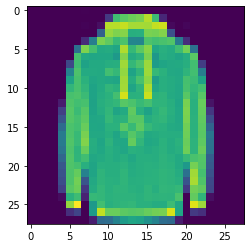

In [0]:
from matplotlib import pyplot as plt

sample_image = x_index[0]
sample_image = sample_image.reshape(1, sample_image.shape[0], sample_image.shape[1]) 
plt.imshow(sample_image[0], interpolation='nearest')
plt.show()

The label corresponding to this image

In [0]:
label  = y_index[0]
label
#2 is a pullover as indicated here: https://github.com/zalandoresearch/fashion-mnist

Out[46]: 2

Test what the recommendations look like for a given image. The model object will return the n (5 in this case) approximately nearest neighbors based on the index in this case.

filtering examples: 0%| | 0/10000 [00:00<?, ?it/s]
selecting classes: 0%| | 0/10 [00:00<?, ?it/s]
gather examples: 0%| | 0/10 [00:00<?, ?it/s]

Performing NN search

Building NN list: 0%| | 0/10 [00:00<?, ?it/s]

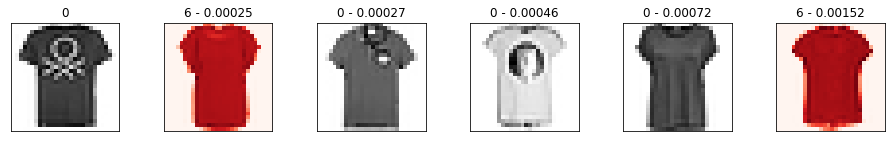

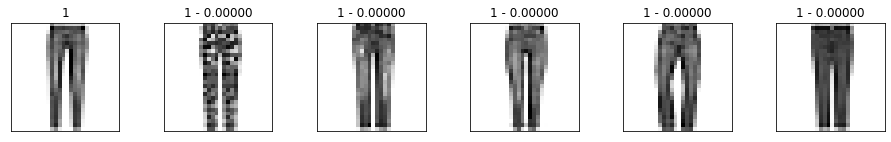

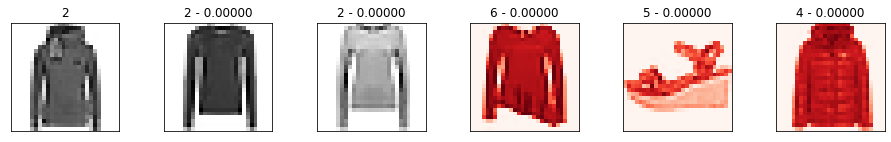

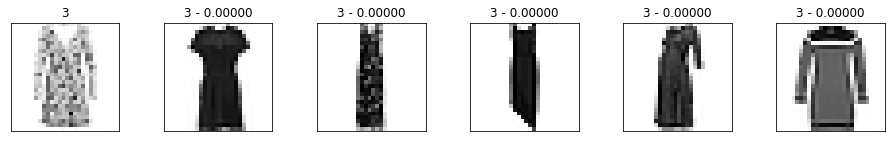

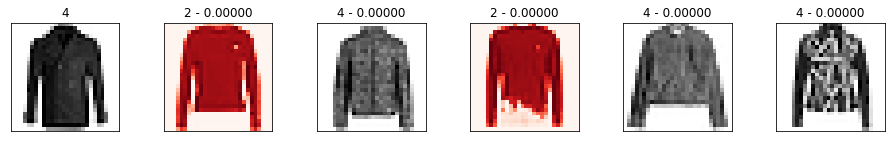

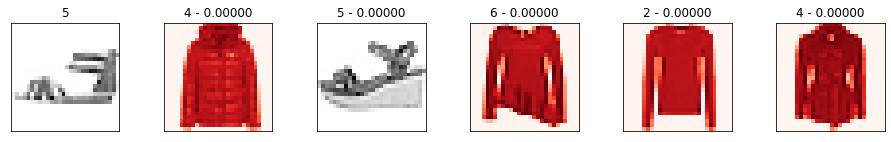

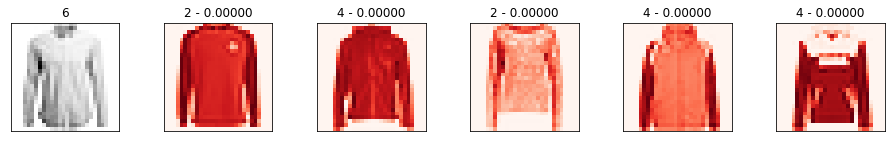

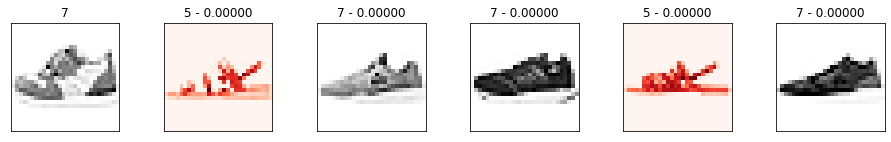

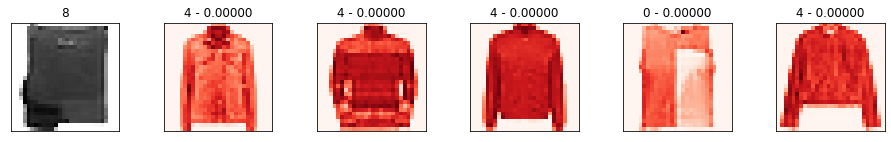

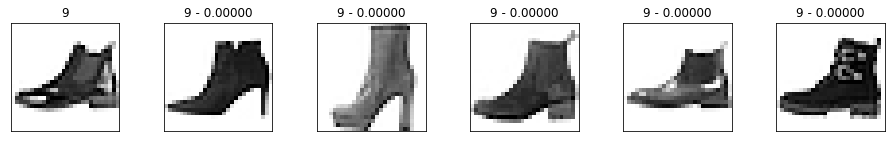

In [0]:
# select
x_display, y_display = select_examples(x_test, y_test, CLASSES, 1)

# lookup nearest neighbors in the index
nns = tfsim_model.lookup(x_display, k=5)

# display
for idx in np.argsort(y_display):
    viz_neigbors_imgs(x_display[idx], y_display[idx], nns[idx], 
                      fig_size=(16, 2), cmap='Greys')

## Create an MLflow Pyfunc wrapper class for deployment and querying

Save the model to a specified directory. This saves the model itself and the index which we use for querying.

In [0]:
tfsim_path = "models/tfsim.pth"

tfsim_model.save(tfsim_path)

WARNING:absl:Found untraced functions such as dense_15_layer_call_and_return_conditional_losses, dense_15_layer_call_fn, dense_15_layer_call_fn, dense_15_layer_call_and_return_conditional_losses, dense_15_layer_call_and_return_conditional_losses while saving (showing 5 of 5). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: models/tfsim.pth/assets
INFO:tensorflow:Assets written to: models/tfsim.pth/assets

Create an `artifacts` dictionary that assigns a unique name to the saved tensorflow_similarity model file.
This dictionary will be passed to `mlflow.pyfunc.save_model`, which will copy the model file
into the new MLflow Model's directory.

In [0]:
# Create an `artifacts` dictionary that assigns a unique name to the saved tensorflow_similarity model file.
# This dictionary will be passed to `mlflow.pyfunc.save_model`, which will copy the model file
# into the new MLflow Model's directory.
artifacts = {
    "tfsim_model": tfsim_path
}

In [0]:
import mlflow.pyfunc 

# Define the model class
import mlflow.pyfunc
class tfsimwrapper(mlflow.pyfunc.PythonModel):

    def load_context(self, context):
        import tensorflow_similarity as tfsim
        from tensorflow_similarity.models import SimilarityModel
        from tensorflow.keras import models

        self.tfsim_model = models.load_model(context.artifacts["tfsim_model"])
        self.tfsim_model.load_index(context.artifacts["tfsim_model"])


    def predict(self, context, model_input):
       #The model_input has to be of the form (1, 28, 28)
        return self.tfsim_model.lookup(model_input, k=5)

In [0]:
from sys import version_info

PYTHON_VERSION = "{major}.{minor}.{micro}".format(major=version_info.major,
                                                  minor=version_info.minor,
                                                  micro=version_info.micro)

Create a Conda environment for the new MLflow Model that contains all necessary dependencies.

In [0]:
import cloudpickle
conda_env = {
    'channels': ['defaults'],
    'dependencies': [
      'python={}'.format(PYTHON_VERSION),
      'pip',
      {
        'pip': [
          'mlflow',
          'tensorflow_similarity=={}'.format(tfsim.__version__),
          'cloudpickle=={}'.format(cloudpickle.__version__),
        ],
      },
    ],
    'name': 'tfsim_env'
}

In [0]:
# Save the MLflow Model
mlflow_pyfunc_model_path = "model/tfsim_mlflow_pyfunc_blog"
mlflow.pyfunc.save_model(
        path=mlflow_pyfunc_model_path, python_model=tfsimwrapper(), artifacts=artifacts,
        conda_env=conda_env)

In [0]:
# Load the model in `python_function` format
loaded_model = mlflow.pyfunc.load_model(mlflow_pyfunc_model_path)

# Evaluate the model
test_predictions = loaded_model.predict(sample_image)
print(test_predictions)


Distance metric automatically set to euclidean use the distance arg to override.
Loading index data
loaded 200 records from /databricks/driver/model/tfsim_mlflow_pyfunc_blog/artifacts/tfsim.pth/index
Loading search index

Performing NN search

Building NN list: 0%| | 0/1 [00:00<?, ?it/s]
[[Lookup(rank=1, distance=3.3905178808296167e-15, label=2, embedding=array([ 0.14048235, 0.01565844, 0.01139351, -0.08651582, 0.00057 ,
 -0.08170256, 0.03691401, 0.03847959, -0.13154545, 0.01799156,
 -0.01246856, -0.0418581 , -0.08011324, -0.0917533 , 0.10603964,
 -0.08948131, 0.08994099, 0.08834706, 0.06316353, -0.00697746,
 0.0117799 , -0.0821825 , 0.1271941 , 0.19375998, 0.17183213,
 -0.05528443, 0.150062 , -0.05496326, 0.0609431 , -0.06346624,
 0.00634338, -0.03869534, 0.10089209, -0.04517926, 0.08076301,
 0.05674792, -0.09079379, 0.13780718, 0.01209509, 0.06117325,
 0.01311811, 0.06289603, -0.11654686, -0.10873215, -0.10149813,
 0.18990985, -0.03873584, -0.19492376, -0.04504116, 0.08636623,
 -0.12786664, 0.12638515, -0.1412356 , 0.00663417, -0.01535416,
 0.0171312 , 0.08913592, 0.10368808, -0.11259903, -0.0742491 ,
 0.08679357, -0.04882104, 0.04882388, -0.11942758, -0.136986 ,
 0.01448299, 0.04500045, -0.07519194, -0.06673015, -0.02072643,
 -0.02707868, 0.03038961, -0.05918231, -0.06239191, -0.14529403,
 -0.05707211, -0.03890685, -0.02560925, 0.03741445, -0.01572185,
 0.02660819, -0.06225671, -0.1652547 , -0.06939138, 0.08618986,
 0.03440432, 0.06976256, 0.08707604, 0.04306142, 0.12955275,
 0.14449078, 0.09673426, -0.02194955, -0.13565019, -0.06751857,
 -0.06283104, 0.03672059, 0.06558666, 0.03279727, 0.04193257,
 0.10704292, -0.06531868, 0.10639268, -0.05562063, -0.08584405,
 -0.05422948, -0.13239217, -0.19447994, 0.12864304, -0.05774058,
 0.12030121, 0.14582647, -0.05075169, 0.04110295, -0.04257042,
 -0.00040619, 0.0217431 , -0.06011236, -0.11375726, -0.0693937 ,
 0.11789437, -0.1297001 , 0.07066871, 0.08589277, -0.10187796,
 0.11752684, -0.09548902, 0.00413749], dtype=float32), data=array([[0. , 0. , 0. , 0. , 0. ,
 0. , 0. , 0.00392157, 0. , 0. ,
 0. , 0. , 0. , 0. , 0. ,
 0. , 0. , 0. , 0. , 0. ,
 0. , 0. , 0. , 0. , 0. ,
 0. , 0. , 0. ],
 [0. , 0. , 0. , 0. , 0. ,
 0. , 0. , 0. , 0. , 0. ,
 0.16470589, 0.69411767, 0.74509805, 0.7764706 , 0.79607844,
 0.8901961 , 0.6862745 , 0.10980392, 0. , 0. ,
 0. , 0. , 0. , 0. , 0. ,
 0. , 0. , 0. ],
 [0. , 0. , 0. , 0. , 0. ,
 0. , 0. , 0.00784314, 0. , 0.03921569,
 0.8901961 , 0.89411765, 0.9137255 , 0.8666667 , 0.8666667 ,
 0.8627451 , 0.9098039 , 0.9254902 , 0.02352941, 0. ,
 0.01568628, 0. , 0. , 0. , 0. ,
 0. , 0. , 0. ],
 [0. , 0. , 0. , 0. , 0. ,
 0. , 0. , 0. , 0. , 0.30588236,
 0.84313726, 0.80784315, 0.81960785, 0.627451 , 0.6313726 ,
 0.8 , 0.7921569 , 0.8156863 , 0.24705882, 0. ,
 0. , 0. , 0. , 0. , 0. ,
 0. , 0. , 0. ],
 [0. , 0. , 0. , 0. , 0. ,
 0. , 0. , 0.12156863, 0.42745098, 0.8 ,
 0.75686276, 0.6745098 , 0.72156864, 0.45882353, 0.45490196,
 0.72156864, 0.69803923, 0.7137255 , 0.7294118 , 0.40784314,
 0.1254902 , 0. , 0. , 0. , 0. ,
 0. , 0. , 0. ],
 [0. , 0. , 0. , 0. , 0. ,
 0. , 0.37254903, 0.80784315, 0.7058824 , 0.60784316,
 0.6156863 , 0.5882353 , 0.88235295, 0.67058825, 0.7490196 ,
 0.8235294 , 0.59607846, 0.6313726 , 0.6156863 , 0.6901961 ,
 0.7882353 , 0.37254903, 0. , 0. , 0. ,
 0. , 0. , 0. ],
 [0. , 0. , 0. , 0. , 0. ,
 0. , 0.7058824 , 0.60784316, 0.5921569 , 0.59607846,
 0.59607846, 0.5372549 , 0.8156863 , 0.6156863 , 0.64705884,
 0.8 , 0.5294118 , 0.62352943, 0.6117647 , 0.58431375,
 0.62352943, 0.74509805, 0. , 0. , 0. ,
 0. , 0. , 0. ],
 [0. , 0. , 0. , 0. , 0. ,
 0.21568628, 0.69411767, 0.5764706 , 0.60784316, 0.60784316,
 0.62352943, 0.627451 , 0.85882354, 0.6666667 , 0.72156864,
 0.8509804 , 0.5529412 , 0.5882353 , 0.6039216 , 0.60784316,
 0.627451 , 0.69803923, 0.18039216, 0. , 0. ,
 0. , 0. , 0. ],
 [0. , 0. , 0. , 0. , 0. ,
 0.44313726, 0.72156864, 0.6117647 , 0.6117647 , 0.60784316,
 0.69803923, 0.6666667 , 0.8392157 , 0.5803922 , 0.654902 ,
 0.854901

Randomly sample an image and query the index. Qualitatively inspect how good the recommendations are.

Performing NN search

Building NN list: 0%| | 0/1 [00:00<?, ?it/s]

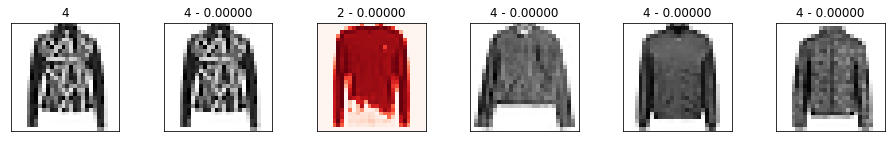

In [0]:
import random
random_index = random.randint(0,199)
test_image = x_index[random_index]
test_image = test_image.reshape(1, test_image.shape[0], test_image.shape[1]) 
test_predictions = loaded_model.predict(test_image)
viz_neigbors_imgs(test_image[0], y_index[random_index], test_predictions[0], 
                      fig_size=(16, 2), cmap='Greys')


- Label	Description
- 0	 T-shirt/top
- 1	 Trouser
- 2	 Pullover
- 3	 Dress
- 4	 Coat
- 5	 Sandal
- 6	 Shirt
- 7	 Sneaker
- 8	 Bag
- 9	 Ankle boot

Deploy the model as a live end point for querying

In [0]:
mlflow.pyfunc.log_model(artifact_path=mlflow_pyfunc_model_path, python_model=tfsimwrapper(), artifacts=artifacts,
        conda_env=conda_env)

mlflow models serve -m 'model/tfsim_mlflow_pyfunc_blog'